In [126]:
import BalloonWindkessel as bw
import matplotlib as plt
from utility import *
pd.options.display.float_format = '{:.3f}'.format
from sklearn.linear_model import LinearRegression

import seaborn as sns
%matplotlib inline


In [2]:
sns.set(font_scale=1.5) 
sns.set_style(style='white') 

# Functions

In [3]:
def sigmoid(x,k=.5,theta=0):
    return 1 / (1 + np.exp(-k*x+theta))
def runSim2D(w, b, s, t, xinit, tau, dt=.1, k=.5,theta=0.):
    def sigmoid(x):
        return 1 / (1 + np.exp(-k * x + theta))
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit[0]
    I2[0] = xinit[1]
    for i in range(1, t):
        d1 = -I1[i - 1] + sigmoid(w[0][0] * I1[i - 1] +w[0][1] * I2[i - 1] + b[0] + s[0][i - 1])
        d2 = -I2[i - 1] + sigmoid(w[1][0] * I1[i - 1] + w[1][1] * I2[i - 1] + b[1] + s[1][i - 1])
        d1 = d1 / tau
        d2 = d2 / tau
        I1t = I1[i - 1] + d1 * dt
        I2t = I2[i - 1] + d2 * dt
        dd1 = -I1t + sigmoid(w[0][0] * I1t +w[0][1] * I2t + b[0] + s[0][i])
        dd2 = -I2t + sigmoid(w[1][0] * I1t + w[1][1] * I2t + b[1] + s[1][i])
        dd1 = dd1 / tau
        dd2 = dd2 / tau
        I1[i] = I1[i - 1] + (d1+dd1)/2 * dt
        I2[i] = I2[i - 1] + (d2+dd2)/2 * dt
    return (I1[25:],I2[25:])

In [4]:
def findFP2d(w, b, t, xinit, tau, dt=.1, eps=1e-6,k=.5,theta=0.):
    def sigmoid(x):
        return 1 / (1 + np.exp(-k * x + theta))
    I1 = np.zeros((t,))
    I2 = np.zeros((t,))
    # Set initial conditions
    I1[0] = xinit[0]
    I2[0] = xinit[1]
    convergeflag=False
    for i in range(1, t):
        d1 = -I1[i - 1] + sigmoid(w[0][0] * I1[i - 1] + w[0][1] * I2[i - 1] + b[0])
        d2 = -I2[i - 1] + sigmoid(w[1][0] * I1[i - 1] + w[1][1] * I2[i - 1] + b[1])
        d1 = d1 / tau
        d2 = d2 / tau
        I1[i] = I1[i - 1] + d1 * dt
        I2[i] = I2[i - 1] + d2 * dt
        if (abs(I1[i]-I1[i - 1])<eps) and (abs(I2[i]-I2[i - 1])<eps):
            I1fp = I1[i]
            I2fp = I2[i]
            convergeflag=True
            return ((I1fp,I2fp),convergeflag)
    return ((I1[-1],I2[-1]),convergeflag)

In [129]:
#b1 and b2 are BOLD signals of nodes of interest
#s1 and s2, and possibly a third signal sc are signals from the rest of the network
#partical correlation compute the correlation of the b1 an b2 after they are residualized agains the network signals
def runPartialCorr(b1,b2,s1,s2,sc=[]):
    if len(sc)==0:
        X=np.array([s1,s2]).T
    else:
        X=np.array([s1,s2,sc]).T
    model=LinearRegression()
    model.fit(X, b1)
 
    residual1 = (b1 - model.predict(X))
    model.fit(X, b2)

    residual2 = (b2 - model.predict(X))
    return (residual1,residual2)
    #return np.corrcoef(residual1,residual2)[0,1]

In [9]:
#v0 is sd of shared input, 0<<ex_shock<=1, that change shared sd by a random factor between ex_shock  and 1/ex_shock
#v0 is negative means input are anti-correlated
#v_ind are idiosynchratic inputs to the nodes
#n is the number of runs
#time step of each run is hard coded #2025
def runscenario(v0,w,n=100,ex_shock=1,wshock=0,v_ind=.35):
    b = -3 #parameters are borrowed from (Ito et al., 2020)
    # Set time constant
    tau = .1
    # Set n timepoints
    t = 2025
    xinit = [0.5, 0.5]
    (xinit, flag) = findFP2d(w, [b, b], 10000, xinit, tau)
    #(xinit, flag) = findFP2d(w, [b,b], 10000, xinit, tau,k=.2,theta=(.5-0.2)*(6*.5+b))
    print('converge ',flag, xinit)
    sd_vals = []
    corr_vals=[]
    pcorr_vals=[]
    I1=[]
    I2=[]
    bold1=[]
    bold2=[]
    boldInput1=[]
    boldInput2=[]
    boldInputS=[]
    sdshock=[]
    weight=w
    for r in range(n):
        sdmult=np.random.uniform(ex_shock,1/ex_shock)
        if (r % 2) == 0:
            shared=sdmult*np.random.normal(0,v0,(t,))
            signal1 = shared+np.random.normal(0,v_ind,(t,))
            if v0<0:
                signal2 = -shared+np.random.normal(0,v_ind,(t,))
            else:
                signal2 = shared+np.random.normal(0,v_ind,(t,))
        else:
            tmp=signal1
            signal1=signal2
            signal2=tmp
        if wshock>0:
            tmpweight=w[1][0]+np.random.uniform(-1*wshock,wshock)
            weight[0][1]=tmpweight
            weight[1][0]=tmpweight
        (s1, s2) = runSim2D(weight, [b, b], [signal1, signal2], t, xinit, tau)
        I1.append(s1)
        I2.append(s2)
        b1=bw.balloonWindkessel(s1.flatten(), sampling_rate=0.1)[0][0]
        b2=bw.balloonWindkessel(s2.flatten(), sampling_rate=0.1)[0][0]
        bold1.append(b1)
        bold2.append(b2)
        sd_vals.append((np.std(b1),np.std(b2)))
        corr_vals.append(np.corrcoef(b1,b2)[0][1])
        sdshock.append(sdmult)

        bs1=bw.balloonWindkessel(np.copy(signal1[25:]-shared[25:]), sampling_rate=0.1)[0][0]
        bs2=bw.balloonWindkessel(np.copy(signal2[25:]-shared[25:]), sampling_rate=0.1)[0][0]
        bs3=bw.balloonWindkessel(np.copy(shared[25:]), sampling_rate=0.1)[0][0]
        pcorr_vals.append(runPartialCorr(b1,b2,bs1,bs2,sc=bs3))

        boldInput1.append(bs1)
        boldInput2.append(bs2)
        boldInputS.append(bs3)
    return bold1,bold2,boldInput1,boldInput2,boldInputS,pcorr_vals
def showresults(I1,I2,bold1,bold2,sd_vals,corr_vals,pcorr_vals,xlim=None,ylim=None):
    s1=I1[-1]
    s2=I2[-1]
    b1=bold1[-1]
    b2=bold2[-1]
    fig,ax=plt.subplots(1,2,figsize=(14,6))
    #ax[0].scatter(x=s1,y=s2)
    ax[0].set_title('Bold Signal b1,b2')
    #ax[0].set_xlabel('x1')
    #ax[0].set_ylabel('x2')
    ax[0].plot(b1,color='blue')
    ax[0].plot(b2,color='orange')
    
    ax[1].scatter(x=b1,y=b2)
    ax[1].set_title('BOLD scatter r='+str(np.round(np.corrcoef(b1,b2)[0,1],2)))
    ax[1].set_xlabel('b1')
    ax[1].set_ylabel('b2')
    ax[1].set_xlim(np.min(b1),np.max(b1))
    ax[1].set_ylim(np.min(b2),np.max(b2))
    plt.show()
    plt.close()
    fig,ax=plt.subplots(1,2,figsize=(14,6))
    x_val=np.array([np.mean(sd)*100 for sd in sd_vals])
    m, b = np.polyfit(x_val, corr_vals, 1)
    corr_sdcorr=np.corrcoef(x_val,corr_vals)[0,1]
    #mean_corr = np.corrcoef(np.array(bold1).flatten(),np.array(bold2).flatten())[0,1]
    mean_corr = np.mean(corr_vals)
    #mean_std=(np.std(np.array(bold1).flatten())+np.std(np.array(bold2).flatten()))/2*100
    mean_std=np.mean(x_val)
    m_new,b_new = np.polyfit(np.abs(x_val-mean_std)*np.sign(np.array(corr_vals)-mean_corr), np.array(corr_vals)-mean_corr, 1)

    print(m_new,b_new)
    
    ax[0].set_title('slope='+str(np.round(m,2))+\
                    ', r='+str(np.round(corr_sdcorr,2))+\
                ', m_corr='+str(np.round(mean_corr,3))+\
             ', m_sd='+str(np.round(mean_std,3)))
    ax[0].scatter(x=x_val,y=corr_vals)
    ax[0].plot(x_val, m*x_val + b)
    ax[0].set_xlabel('sd')
    ax[0].set_ylabel('corr')

    if len(pcorr_vals)>0:
        ax[1].set_title('r='+str(np.round(np.corrcoef(corr_vals,pcorr_vals)[0,1],2))+
                             ', m_pcorr='+str(np.round(np.mean(pcorr_vals),2)))
        ax[1].scatter(x=pcorr_vals,y=corr_vals)
        ax[1].set_xlabel('pcorr')
        ax[1].set_ylabel('corr')
    if xlim!=None:
        ax[0].set_xlim(xlim[0],xlim[1])
    
    if ylim!=None:
        ax[0].set_ylim(ylim[0],ylim[1])
    plt.show()
    

# choosing benchmark parameter to be realist, wrt empiracle data
i.e., baseline correlation (FC) is .527

In [99]:
#benchmark
w = [[2,1],[1,2]]
v_ind=0.35
v0=.25
#I1,I2,bold1,bold2,sd_vals,corr_vals,pcorr_vals,sdshock=runscenario(.75,w,ex_shock=.8,n=1000)
bold1,bold2,bs1,bs2,bsS,pcorr_vals=runscenario(v0,w,n=1000)

converge  True (0.24320398810103175, 0.24320398810103175)


In [104]:
baseDF=pd.DataFrame({'corr':[np.corrcoef(x[0],x[1])[0][1] for x in zip(bold1,bold2)],
              'var1':np.var(bs1,axis=1),
              'var2':np.var(bs2,axis=1),
              'varS':np.var(bsS,axis=1)})
baseDF.describe()

,corr,var1,var2,varS
count,1000.000,1000.000,1000.000,1000.000
mean,0.527,0.000,0.000,0.000
std,0.093,0.000,0.000,0.000
min,0.255,0.000,0.000,0.000
25%,0.464,0.000,0.000,0.000
50%,0.535,0.000,0.000,0.000
75%,0.593,0.000,0.000,0.000
max,0.719,0.000,0.000,0.000


In [106]:
reg = LinearRegression().fit(baseDF[['var1','var2','varS']].values, baseDF['corr'].values)
(reg.coef_,reg.intercept_)

(array([-1087.62391444, -1087.62391444,  5808.3593173 ]), 0.48983037988504446)

In [107]:
betas=reg.coef_ #baseline sensitivity
baseCorr=baseDF['corr'].mean() #baseline correlation
baseVar1=baseDF['var1'].mean() #unshared input variance
baseVar2=baseDF['var2'].mean() #unshared input vairance
baseVarS=baseDF['varS'].mean() #shared input variance
basePcorr=np.mean(pcorr_vals)
(baseCorr,basePcorr)

(0.5269397983573402, 0.42099381583840145)

# scenarios varying parameters

## local coupling change

In [108]:
output1=pd.DataFrame()
w = [[2,1],[1,2]]
v_ind=0.35
v0=.25
for weight in [.4,.7,1.3,1.6]:
    w = [[2,weight],[weight,2]]
    b1,b2,s1,s2,share,pcorr=runscenario(v0,w,n=200)
    output1=pd.concat([output1,pd.DataFrame({'corr':[np.corrcoef(x[0],x[1])[0][1] for x in zip(b1,b2)],
                                             'var1':np.var(s1,axis=1),
                                              'var2':np.var(s2,axis=1),
                                              'varS':np.var(share,axis=1),
                                            'pcorr':pcorr,
                                            'w':weight})])

converge  True (0.2264959691380496, 0.2264959691380496)
converge  True (0.2344169731440906, 0.2344169731440906)
converge  True (0.2530347628064056, 0.2530347628064056)
converge  True (0.26414409388490784, 0.26414409388490784)


In [110]:
output1['FC chg']=output1['corr']-baseCorr
output1['comm chg']=output1['FC chg']-betas[0]*(output1['var1']-baseVar1)-\
                            betas[1]*(output1['var2']-baseVar2)-\
                            betas[2]*(output1['varS']-baseVarS)
output1['pcorr chg']=output1['pcorr']-basePcorr

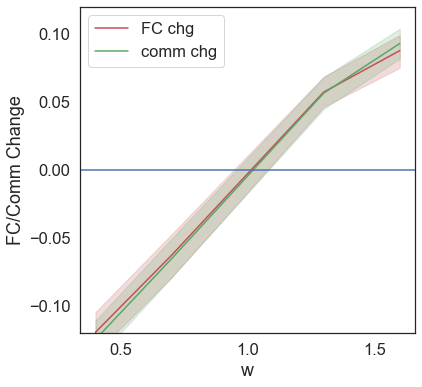

In [111]:
fig, ax = plt.subplots(figsize=(6,6))
plotdata=pd.melt(output1,id_vars='w',value_vars=['FC chg','comm chg'])
g = sns.lineplot(data=plotdata, x="w", y="value",hue='variable',ax=ax,palette=['r', 'g'])
g.set_xticks(np.linspace(.5,1.5,3))
g.axhline(0)
g.set_ylabel('FC/Comm Change')
g.set_ylim(-.12,.12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.legend(title='')
plt.show()
plt.close()

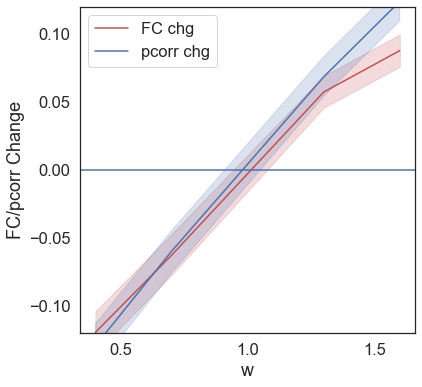

In [112]:
fig, ax = plt.subplots(figsize=(6,6))
plotdata=pd.melt(output1,id_vars='w',value_vars=['FC chg','pcorr chg'])
g = sns.lineplot(data=plotdata, x="w", y="value",hue='variable',ax=ax,palette=['r', 'b'])
g.axhline(0)
g.set_xticks(np.linspace(.5,1.5,3))
g.set_ylim(-.12,.12)
g.set_ylabel('FC/pcorr Change')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.legend(title='')
plt.show()
plt.close()

## shared input changes

In [113]:
output2=pd.DataFrame()
w = [[2,1],[1,2]]
for v in [0.18,.23,.28,.33]:
    b1,b2,s1,s2,share,pcorr=runscenario(v,w,n=200)
    output2=pd.concat([output2,pd.DataFrame({'corr':[np.corrcoef(x[0],x[1])[0][1] for x in zip(b1,b2)],
                                             'var1':np.var(s1,axis=1),
                                              'var2':np.var(s2,axis=1),
                                              'varS':np.var(share,axis=1),
                                            'pcorr':pcorr,
                                            'v':v})])

converge  True (0.24320398810103175, 0.24320398810103175)
converge  True (0.24320398810103175, 0.24320398810103175)
converge  True (0.24320398810103175, 0.24320398810103175)
converge  True (0.24320398810103175, 0.24320398810103175)


In [114]:
output2['FC chg']=output2['corr']-baseCorr
output2['comm chg']=output2['FC chg']-betas[0]*(output2['var1']-baseVar1)-\
                            betas[1]*(output2['var2']-baseVar2)-\
                            betas[2]*(output2['varS']-baseVarS)
output2['pcorr chg']=output2['pcorr']-basePcorr

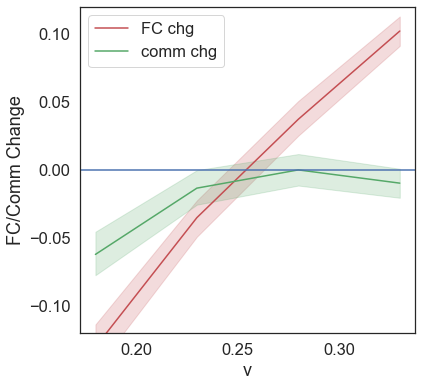

In [115]:
fig, ax = plt.subplots(figsize=(6,6))
plotdata=pd.melt(output2.dropna(),id_vars='v',value_vars=['FC chg','comm chg'])
g = sns.lineplot(data=plotdata, x="v", y="value",hue='variable',ax=ax,palette=['r', 'g'])
g.set_xticks(np.linspace(.2,.3,3))
g.axhline(0)
g.set_ylabel('FC/Comm Change')
g.set_ylim(-.12,.12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.legend(title='')
plt.show()
plt.close()

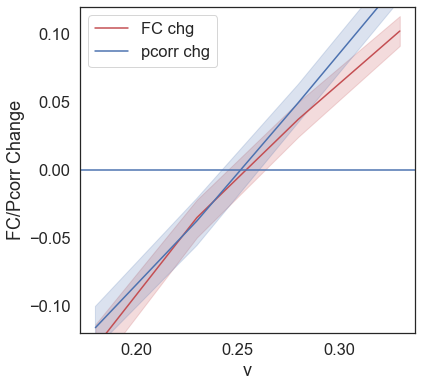

In [116]:
fig, ax = plt.subplots(figsize=(6,6))
plotdata=pd.melt(output2,id_vars='v',value_vars=['FC chg','pcorr chg'])
g = sns.lineplot(data=plotdata, x="v", y="value",hue='variable',ax=ax,palette=['r', 'b'])
g.set_xticks(np.linspace(.2,.3,3))
g.axhline(0)
g.set_ylabel('FC/Pcorr Change')
g.set_ylim(-.12,.12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.legend(title='')
plt.show()
plt.close()

In [ ]:
## unshared input changes

In [121]:
output3=pd.DataFrame()
w = [[2,1],[1,2]]
v_ind=0.35
v0=.25
for v_i in [0.25,.32,.38,.45]:
    b1,b2,s1,s2,share,pcorr=runscenario(v0,w,n=200,v_ind=v_i)
    output3=pd.concat([output3,pd.DataFrame({'corr':[np.corrcoef(x[0],x[1])[0][1] for x in zip(b1,b2)],
                                             'var1':np.var(s1,axis=1),
                                              'var2':np.var(s2,axis=1),
                                              'varS':np.var(share,axis=1),
                                            'pcorr':pcorr,
                                            'v_ind':v_i})])

converge  True (0.24320398810103175, 0.24320398810103175)
converge  True (0.24320398810103175, 0.24320398810103175)
converge  True (0.24320398810103175, 0.24320398810103175)
converge  True (0.24320398810103175, 0.24320398810103175)


In [122]:
output3['FC chg']=output3['corr']-baseCorr
output3['comm chg']=output3['FC chg']-betas[0]*(output3['var1']-baseVar1)-\
                            betas[1]*(output3['var2']-baseVar2)-\
                            betas[2]*(output3['varS']-baseVarS)
output3['pcorr chg']=output3['pcorr']-basePcorr

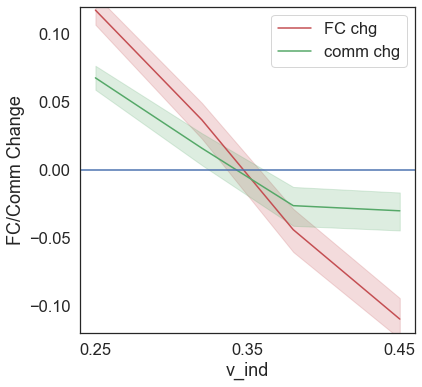

In [123]:
fig, ax = plt.subplots(figsize=(6,6))
plotdata=pd.melt(output3,id_vars='v_ind',value_vars=['FC chg','comm chg'])
g = sns.lineplot(data=plotdata, x="v_ind", y="value",hue='variable',ax=ax,palette=['r', 'g'])
g.set_xticks(np.linspace(.25,.45,3))
g.axhline(0)
g.set_ylabel('FC/Comm Change')
g.set_ylim(-.12,.12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.legend(title='')
plt.show()
plt.close()

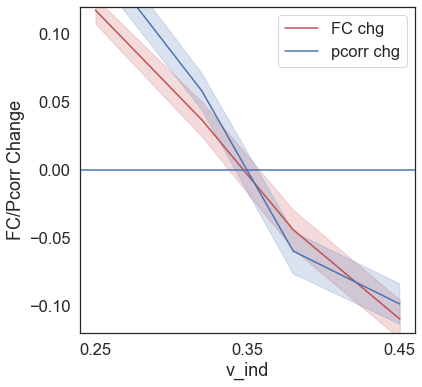

In [124]:
fig, ax = plt.subplots(figsize=(6,6))
plotdata=pd.melt(output3,id_vars='v_ind',value_vars=['FC chg','pcorr chg'])
g = sns.lineplot(data=plotdata, x="v_ind", y="value",hue='variable',ax=ax,palette=['r', 'b'])
g.set_xticks(np.linspace(.25,.45,3))
g.axhline(0)
g.set_ylabel('FC/Pcorr Change')
g.set_ylim(-.12,.12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.legend(title='')
plt.show()
plt.close()